## Biobjective otimization of the model's parameters for prediction of output voltage of the Buck converter CC-CC using as objectives the static curve information and the prediction error 


# Example: Buck converter

Example created by Gabriel Bueno Leandro

<div style="text-align: justify"> A buck converter is a type of DC/DC converter that decreases the voltage (while increasing the current) from its input (power supply) to its output (load). It is similar to a boost converter (elevator) and is a type of switched-mode power supply (SMPS) that typically contains at least two semiconductors (a diode and a transistor, although modern buck converters replace the diode with a second transistor used for synchronous rectification) and at least one energy storage element, a capacitor, inductor or both combined. </div>

In [25]:
# Importing the libraries and methods needed to run the notebook.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sysidentpy.model_structure_selection import FROLS
from sysidentpy.multiobjective.multiobjective_parameter_estimation import IM
from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_results
from sysidentpy.metrics import root_relative_squared_error

## Dynamic Behavior

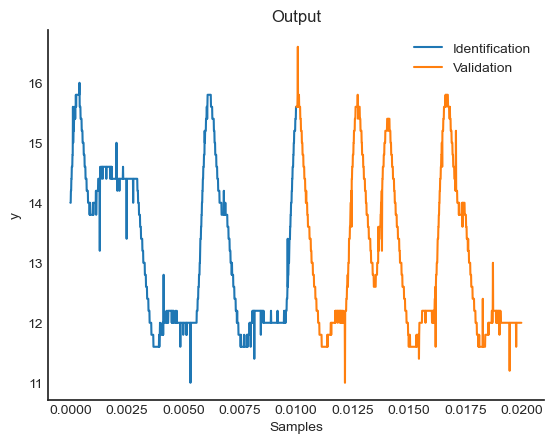

In [26]:
# Reading Buck's input and output data
data_train = pd.read_csv(r'datasets/buck.txt' , sep=" ", header=None).to_numpy()
data_valid = pd.read_csv(r'datasets/buck_val.txt' , sep =" ", header=None).to_numpy()

# Separating the identification data
data_samples_train = data_train[:, 2]
data_out_train = data_train[:, 6]
data_int_train = data_train[:, 4]

# Separating the validation data
data_samples_valid = data_valid[:, 2]
data_out_valid = data_valid[:, 6]
data_int_valid = data_valid[:, 4]

# Plotting the measured output (identification and validation data)
plt.figure(1)
plt.title('Output')
plt.plot(data_samples_train, data_out_train, label='Identification', linewidth=1.5)
plt.plot(data_samples_valid, data_out_valid , label='Validation', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('y')
plt.legend()
plt.show()


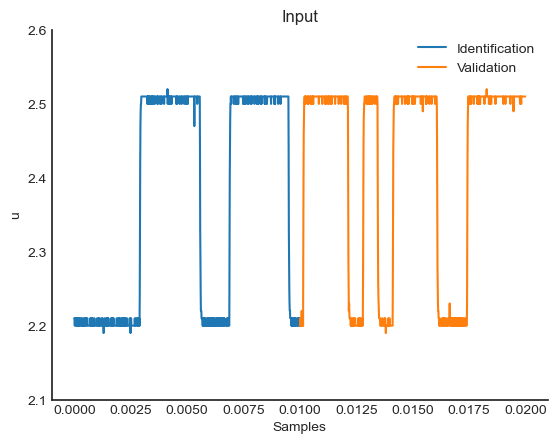

In [27]:
# Plotting the measured input(identification and validation data)
plt.figure(2)
plt.title('Input')
plt.plot(data_samples_train, data_int_train, label='Identification', linewidth=1.5)
plt.plot(data_samples_valid, data_int_valid, label='Validation', linewidth=1.5)
plt.ylim(2.1, 2.6)
plt.ylabel('u')
plt.xlabel('Samples')
plt.legend()
plt.show()

# Buck converter static gain

The gain is represented by:

$$
\bar{g_i} = \frac{d\bar{y}}{d\bar{u}} \bigg|_{(\bar{u_i}, \bar{y_i})},
$$

but note that the equation $\bar{y} = f(\bar{y}, \bar{u})$ defines implicitly $\bar{y}$ as a function of $\bar{u}$. Being its derivative:

$$
\frac{d\bar{y}}{d\bar{u}} = -\frac{\partial[f(\bar{y}, \bar{u}) - \bar{y}]}{\partial\hat{u}} \bigg(\frac{\partial[f(\bar{y}, \bar{u}) - \bar{y}]}{\partial\bar{y}}\bigg)^{-1},
$$

where:

$$
\bar{g_i}\frac{\partial\bar{y}}{\partial\bar{u}} \bigg|_{(\bar{u_i}, \bar{y_i})} - \bar{g_i} = -\frac{\partial\bar{y}}{\partial\bar{u}} \bigg|_{(\bar{u_i}, \bar{y_i})} ,
$$

still:

$$
\frac{\partial f}{\partial \bar{y}} = \frac{\partial q^T}{\partial \bar{y}} R\theta,\:and\:\frac{\partial f}{\partial \bar{u}} = \frac{\partial q^T}{\partial \bar{u}} R\theta,
$$

soon:

$$
(\bar{g_i}\Gamma_i^T+\Omega_i^T)R\theta = \bar{g_i} \Longrightarrow HR\theta = \bar{g},
$$

such that:such that:

$$
H =
\begin{bmatrix}
\bar{g_1}\Gamma_1^T + \Omega_1^T\\
\bar{g_2}\Gamma_2^T + \Omega_2^T\\
\vdots\\
\bar{g}_{nsg}\Gamma_{nsg}^T + \Omega_{nsg}^T\\
\end{bmatrix}
$$

the quadratic error can be expressed by:

$$
J_{SG} = (\bar{g}-HR\hat{\theta})^T(\bar{g}-HR\hat{\theta})
$$


### Buck Converter: In practice

The gain of the Buck converter can be described as the derivative of the static function, which is described by:

$$
V_o = (4 - \bar{u})\cdot 8
$$

soon $gain=V_o'=-8$

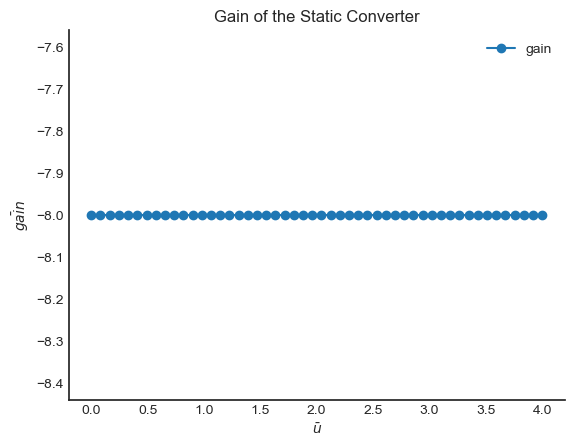

In [28]:
# Defining the gain
Vd = 24
Uo = np.linspace(0, 4, 50)
Yo = (4-Uo)*Vd/3
gain = -8*np.ones(len(Uo)).reshape(-1, 1)
Uo = Uo.reshape(-1, 1)
Yo = Yo.reshape(-1, 1)
gain = gain.reshape(-1, 1)
plt.figure(3)
plt.title('Gain of the Static Converter')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{gain}$')
plt.plot(Uo, gain, linewidth=1.5, label='gain', linestyle='-', marker='o')
plt.legend()
plt.show()

entering with validation and training data:

In [29]:
# Informing test and validation data
x_train = data_int_train.reshape(-1, 1)
y_train = data_out_train.reshape(-1, 1)
x_valid = data_int_valid.reshape(-1, 1)
y_valid = data_out_valid.reshape(-1, 1)

basis_function = Polynomial(degree=2)

model = FROLS(
    order_selection=True,
    n_info_values=8,
    extended_least_squares=False,
    ylag=2, xlag=2,
    info_criteria='aic',
    estimator='least_squares',
    basis_function=basis_function
)

model.fit(X=x_train, y=y_train)

C:\Users\55359\OneDrive\Área de Trabalho\Clone_git\sysidentpy\sysidentpy\utils\deprecation.py:37: FutureWarning: Passing a string to define the estimator will rise an error in v0.4.0. 
 You'll have to use FROLS(estimator=LeastSquares()) instead. 
 The only change is that you'll have to define the estimator first instead of passing a string like 'least_squares'. 
 This change will make easier to implement new estimators and it'll improve code readability.
  warnings.warn(message, FutureWarning)


Calling the class to calculate the parameters via the multi-objective method: 

In [30]:
# Calling the class referring to the calculation of the parameters via the multiobjective technique
mult = IM(sf=False, sg=True, model_type='NARMAX',
        final_model = model.final_model, 
        norm=False)

the method requires entering with the dynamic output, static input and output, gain, and PSI: 

In [31]:
# Method to calculate the parameters
              #[0.0068874]])
J, w, E, Theta, HR, QR, position = mult.affine_information_least_squares(y_train=y_train[2:],
                                                                         gain=gain,y_static=Yo,
                                                                         x_static=Uo, psi=model.psi)
result = {'w1': w[0,:],
          'w2': w[1,:],
          'J_ls': J[0,:],
          'J_sg': J[1,:],
          '||J||:': E}
pd.DataFrame(result)


,w1,w2,J_ls,J_sg,||J||:
0,0.006842,0.993158,16.613100,8.035401e-09,16.613100
1,0.007573,0.992427,16.613100,1.011570e-08,16.613100
2,0.008382,0.991618,16.613100,1.262598e-08,16.613100
3,0.009277,0.990723,16.613100,1.496741e-08,16.613100
4,0.006842,0.993158,16.613100,8.035401e-09,16.613100
...,...,...,...,...,...
2290,0.659632,0.340368,16.612506,5.550769e-04,16.612506
2291,0.730119,0.269881,16.612303,1.024927e-03,16.612303
2292,0.808139,0.191861,16.611942,2.268984e-03,16.611942
2293,0.894495,0.105505,16.611080,7.674518e-03,16.611082


In [32]:
# Writing the results
model.theta = Theta[position, :].reshape(-1,1)
yhat = model.predict(X=x_valid, y=y_valid)
rrse = root_relative_squared_error(y_valid, yhat)
r = pd.DataFrame(
    results(
        model.final_model, model.theta, model.err,
        model.n_terms, err_precision=3, dtype='sci'
        ),
    columns=['Regressors', 'Parameters', 'ERR'])
r

,Regressors,Parameters,ERR
0,y(k-1),4.1690E-01,9.999E-01
1,y(k-2),6.1985E-01,2.042E-05
2,x1(k-1)y(k-1),-3.3100E-02,1.108E-06
3,1,3.8073E-01,4.688E-06
4,y(k-1)^2,2.7551E-01,3.922E-07
5,x1(k-1),6.4079E-02,8.389E-07
6,y(k-2)y(k-1),-5.3494E-01,5.690E-07
7,y(k-2)^2,2.5947E-01,3.827E-06


dynamic data in graphical form:

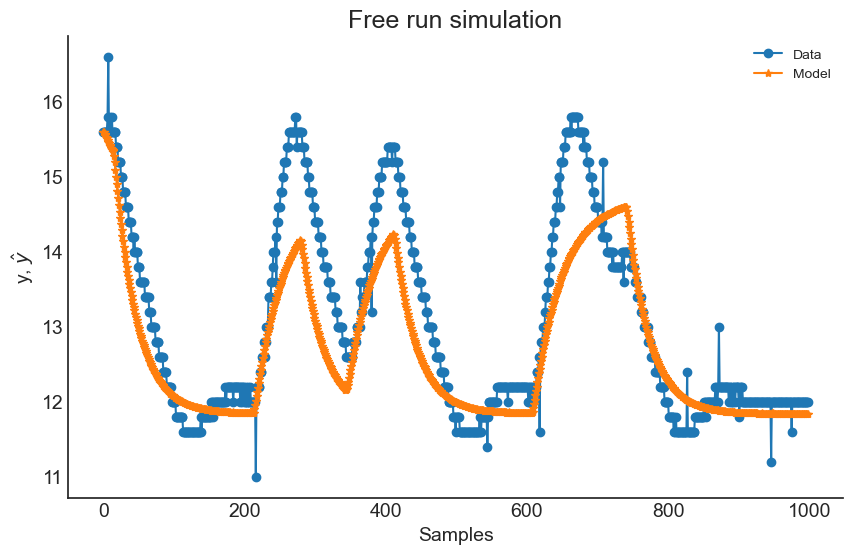

In [33]:
plot_results(y=y_valid, yhat=yhat, n=1000)

the static gain graphically:

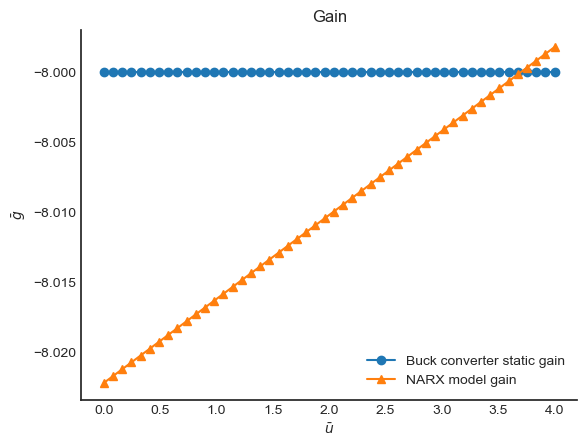

In [34]:
plt.figure(4)
plt.title('Gain')
plt.plot(Uo, gain, linewidth=1.5, linestyle='-', marker='o', label='Buck converter static gain')
plt.plot(Uo, HR.dot(model.theta),  linestyle='-', marker='^', linewidth=1.5, label='NARX model gain')
plt.xlabel('$\\bar{u}$')
plt.ylabel('$\\bar{g}$')
plt.legend()
plt.show()